In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
# # install conda (this restarts the colab kernel -- wait until restart before running subsequent blocks)

# !pip install condacolab
# import condacolab
# condacolab.install_miniconda()

In [3]:
# !pip install geopandas
# !pip install hyperopt

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import xgboost

# from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [4]:
from typing import List, Union
from pathlib import Path
from functools import reduce
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             average_precision_score, precision_recall_curve, auc, PrecisionRecallDisplay,
							 confusion_matrix, roc_curve, RocCurveDisplay
							 )
import sklearn.metrics

import gtc_functions


# Function definitions

In [39]:
def check_files_in_list_exist(
    file_list: Union[List[str], List[Path]]
    ):
    """State which files don't exist and remove from list"""
    files_found = []
    for fl in file_list:
        # attempt conversion to Path object if necessary
        if type(fl) != Path:
            try:
                fl = Path(fl)
            except TypeError:
                print(f'{fl} could not be converted to Path object')
        
        if fl.is_file():
            files_found += fl,
        else:
            print(f'{fl} not found. Removing from list.')

    return files_found


def read_and_merge_pkls(
    pkl_paths: Union[List[str], List[Path]]
) -> pd.DataFrame:
    """Read in pkl files from list of file paths and merge on index"""
    # check all files exist
    pkl_paths_present = check_files_in_list_exist(pkl_paths)
    df_list = [gtc_functions.standardise_df(pd.read_pickle(pkl)) for pkl in pkl_paths_present]

    return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


def rename_and_drop_duplicated_cols(
    df: pd.DataFrame
) -> pd.DataFrame:
    """Drop columns which are copies of others and rename the 'asdf_x' headers which would have resulted"""
    # need to ensure no bad types first
    df = drop_cols_containing_lists(df)
    # remove duplicated columns
    dropped_df = df.T.drop_duplicates().T
    # rename columns for clarity (especially those which are shared between dfs). Will be able to remove most with better
    # column naming further up the process
    new_col_names = {col: col.replace('_x', '') for col in dropped_df.columns if col.endswith('_x')}
    
    return dropped_df.rename(columns=new_col_names)


def drop_cols_containing_lists(
    df: pd.DataFrame
) -> pd.DataFrame:
    """It seemed like the best solution at the time: and to be fair, I can't really think of better...
    N.B. for speed, only looks at values in first row – if there is a multi-type column, this would be the least of
    our worries...
    """
    df = df.loc[:, df.iloc[0].apply(lambda x: type(x) != list)]

    return df


def assign_predictor(
    df: pd.DataFrame,
    col_name: str,
    drop_classes: List[int],
    binary_classification: bool = True
) -> pd.DataFrame:
    """Assign column as predictor value, and choose whether binary or multi-class classification. Can choose to drop
    classes."""
    df["y"] = df[col_name].astype(int)

    if binary_classification:
        df.loc[df["y"] > 0, "y"] = 1

    # drop any classes in 
    df = df.loc[~df['y'].isin(drop_classes)]

    return df


def replace_cols_with_mean(
    df: pd.DataFrame, 
    col_names: List[str]
) -> pd.DataFrame:
    """Replace values in a column with the mean value"""
    for col in col_names:
        df.loc[df[col] == 0, col] = df[col][df[col] > 0].mean()
    
    return df


def train_test_display_model(
    df: pd.DataFrame,
    var_col_names: List[str],
    model_name: str = 'LogisticRegression',
    y_col: str = 'y',
    test_size: float = 0.25,
    random_state: int = 1
) -> list:
    """Specify columns in a df to use to train and test model. Currently available models: 'LogisticRegression', 
    'RandomForest'

    TODO: should I put this in a class?"""

    x_train, x_test, y_train, y_test = train_test_split(
        df[var_col_names],
        df[y_col],
        test_size=test_size,random_state=random_state)

    # select chosen model
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.coef_[0]
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.feature_importances_  

    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    y_score = model.predict_proba(x_test)

    fig,(ax_imp,ax_conf) = plt.subplots(1, 2, figsize=[22,10])
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'Current model: {model_name.upper()}')

    plot_confusion_matrix(y_test, predictions, score, ax=ax_conf)
    plot_importances(var_col_names, importance, ax=ax_imp)
    plt.show()

    more_performance_scores(predictions,y_test)

    return model, predictions, x_train, x_test, y_train, y_test, score, y_score, importance


def more_performance_scores(
    predictions: List,
    y_test: List
):
    """Return extra performance scores"""

    # F1 score = (2*precision*recall)/(precision+recall)
    f1_score_val = f1_score(predictions, y_test, average=None)
    f1_score_macro = f1_score(predictions, y_test, average='macro')
    f1_score_weighted = f1_score(predictions, y_test, average='weighted')
    print(f'f1 score per class: {f1_score_val}')
    print(f'f1 score macro: {f1_score_macro}')
    print(f'weighted f1 score: {f1_score_weighted}')  # seems weirdly high

    # precision
    print(f'precision score: {precision_score(predictions, y_test, average=None)}')

    # recall
    print(f'recall score: {recall_score(predictions, y_test, average=None)}')
    # balanced accuracy (unweighted average of recall obtained on each class)
    bal_acc = recall_score(predictions, y_test, average='macro')
    print(f'balanced accuracy: {bal_acc}')

    # accuracy (true predictions, OvR over all predictions)
    print(f'accuracy_score: {accuracy_score(predictions, y_test)}')


def plot_confusion_matrix(
    y_test: list,
    predictions: list,
    score: float,
    ax=None
):
    """Plot confusion matrix from y_test and inferred values"""

    conf_matrix = confusion_matrix(y_test, predictions)
    # initialise axes if necessary
    ax = ax or plt.gca()
    sns.heatmap(conf_matrix/np.sum(conf_matrix), ax=ax, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
    # formatting
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    # assign integer damage classes to labels
    xtick_labels = [int_to_label(el) for el in range(len(conf_matrix))]
    ax.set_xticks(ax.get_xticks(), xtick_labels, rotation=45)
    ax.set_yticks(ax.get_yticks(), xtick_labels, rotation=45)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()

    if len(conf_matrix) == 2:  # binary classification
      ax.set_title(f'Confusion matrix for binary classification \n Score: {score:.4f}', fontsize=18)
    else: # multiclass classification
      ax.set_title(f'Confusion matrix for multiclass classification \n Score: {score:.4f}', fontsize=18)

    return ax


def plot_importances(
    var_col_names: List[str],
    importances: List[float],
    num_params_to_show: int = None,
    ax=None
):
    """Visualise feature importance"""
    # initialise axes if necessary
    ax = ax or plt.gca()

    data = dict(zip(var_col_names, importances))
    sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))
    
    # if specified to show fewer, remove all but greatest n values
    if type(num_params_to_show) == int:
        nth_val = sorted(sorted_data.values(), reverse=True)[num_params_to_show-1]
        sorted_data = {k: v for k, v in sorted_data.items() if v >= nth_val}
        
    ax.barh(list(sorted_data.keys()), list(sorted_data.values()))

    # formatting
    ax.set_ylabel('Input variable')
    ax.set_xlabel('Feature importance')

    if type(num_params_to_show) == int:
        ax.set_title(f'Feature importance for model\nTop {num_params_to_show} most significant features', fontsize=18)
    else:
        ax.set_title('Feature importance for model\nAll features', fontsize=18)

    ax.grid(which='both', linewidth=0.3)
    ax.set_xlim(right=1.15*max(importances))

    for i, v in enumerate(sorted_data.values()):
        ax.text(v+.02*max(importances), i, f'{v:.3f}', ha='left', va='center_baseline')

    return ax


def train_test_model(
    model,
    trains: List[List],
    tests: List[List]
) -> List:
    """Train provided model. Trains in format [x_train, y_train]; similar with tests"""
    model.fit(trains[0], trains[1])
    predictions = model.predict(tests[0])
    model.score(tests[0], tests[1])

    return model


def plot_roc_curves(
    y_test: List[int],
    y_score: List[float]
):
    """Plot ROC (receiver operating characteristic) curve for each class"""
    fig, axes = plt.subplots(len(np.unique(y_test))//2, len(np.unique(y_test))//2, figsize=[15,15])
    axes = axes.ravel()
    clsses = [str(el) for el in np.unique(y_test)]

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    for i,clss in enumerate(np.unique(y_test)):
        class_id = np.flatnonzero(label_binarizer.classes_ == clss)[0]

        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{clss} vs the rest",
            color="darkorange",
            ax=axes[i]
        )

        axes[i].set_aspect('equal')
        axes[i].plot([0, 1], [0, 1], "k--", label="random choice level (AUC = 0.5)")
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].grid(which='both', linewidth=0.3)
        not_clss_list = '&'.join([x for x in clsses if x != str(clss)])
        axes[i].set_title(f"One-vs-Rest ROC curves:\n{int_to_label(clss)} vs {not_clss_list}")


# ROC AUC via macro average = (prec_1 + prec_2 + ... + prec_n) / n since imbalanced dataset
def plot_pr_curves(
    y_test: List[int],
    y_score: List[float]
):
    """Plot PR (precision-recall) curve for each class"""
    
    fig, axes = plt.subplots(len(np.unique(y_test))//2, len(np.unique(y_test))//2, figsize=[15,15])
    axes = axes.ravel()
    clsses = [str(el) for el in np.unique(y_test)]

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    for i,clss in enumerate(np.unique(y_test)):
        PrecisionRecallDisplay.from_predictions(
            y_onehot_test[:, i], y_score[:, i], name='name', ax=axes[i])
        # formatting
        not_clss_list = '&'.join([x for x in clsses if x != str(clss)])
        axes[i].set_title(f"One-vs-Rest P-R curves:\n{int_to_label(clss)} vs {not_clss_list}")
        axes[i].grid(which='both', linewidth=0.3)


def calc_curves_macro_av(
    y_test: List[float],
    y_score: List[float],
    curve_type: str = 'pr'
):  
    """Calculate the macro average from a set of performance curves
    N.B. adapted largely from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    
    Parameters
    ----------
    y_test : List[float]
    y_score : List[float]
    curve_type : str defaults to 'pr'
        required curve. This can be either 'pr' (precision-recall) or 'roc' (receiver operating characteristic)
    """
    # store the fpr, tpr, and roc_auc for all averaging strategies
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    x_stats, y_stats, curve_aucs = dict(), dict(), dict()
    
    for i in range(np.shape(y_score)[1]):
        if curve_type == 'roc':
            x_stats[i], y_stats[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        elif curve_type == 'pr':
            y_stats[i], x_stats[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
        else:
            raise ValueError(f'Unknown curve type: {curve_type}')
        curve_aucs[i] = auc(x_stats[i], y_stats[i])
    
    ### TODO: comment and check functionality – seems too good! Think a debug would be useful here...
    # TODO: make sure all stats calculated
    # TODO: what's up with the fourth P-R curve?
    
    grid = np.linspace(0.0, 1.0, 1000)
    # Interpolate all ROC curves at these points
    mean_stat = np.zeros_like(grid)

    for i in range(len(x_stats)):
        mean_stat += np.interp(grid, x_stats[i], y_stats[i])  # linear interpolation

    # Average it and compute AUC
    mean_stat /= len(x_stats)

    x_stats["macro"] = grid
    y_stats["macro"] = mean_stat
    curve_aucs["macro"] = auc(x_stats["macro"], y_stats["macro"])

    print(f"Macro-averaged One-vs-Rest {curve_type.upper()} AUC score:\n{curve_aucs['macro']:.2f}")


def int_to_label(
    integer: int
) -> str:
    """Convert a numerical label to its corresponding text label"""
    label_dict = {0: 'undamaged', 1: 'minor damage', 2: 'major damage', 3: 'destroyed', 4: 'unclassified'}

    return label_dict[integer]


def pca_analysis(
    df: pd.DataFrame,
    feature_cols: list[str],
    target_col: str,
    components = None
):
    """Apply and visualise rudimentary PCA. Returns percentage variances, cumulative percentage variances, and plots
    explained variance against number of input features

    helped largely by this: https://towardsdatascience.com/using-principal-component-analysis-pca-for-machine-learning-b6e803f5bf1e
    TODO: better commenting, write documentation
    """
    # get the features and label from the original dataframe
    X = df[feature_cols]
    y = df[target_col]

    # performing standardization
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)

    pca = PCA(n_components = components)
    # perform PCA on the scaled data
    pca.fit(X_scaled);

    # print the explained variances
    print("Variances (Percentage):")
    print(pca.explained_variance_ratio_ * 100)
    print("Cumulative Variances (Percentage):")
    print(pca.explained_variance_ratio_.cumsum() * 100)

    plot_scree_plot(pca, components)


def plot_scree_plot(
    pca,
    components = None
):
    """Plot scree plot for PCA visualisation"""
    components = len(pca.explained_variance_ratio_) \
        if components is None else components

    _,ax = plt.subplots()
    ax.plot(range(1,components+1), 
            np.cumsum(pca.explained_variance_ratio_ * 100))
    ax.set_xlabel("Number of components")
    ax.set_ylabel("Explained variance (%)")
    ax.set_title('Scree plot for trained model')
    ax.hlines(xmin=0,xmax=components, y=95, color='k', linestyle='dotted', label='95% explained variance')
    ax.grid(which='major', linewidth=0.3)
    ax.grid(which='minor', linewidth=0.1)
    ax.set_xlim(xmin=0, xmax=components)
    plt.legend()
    plt.minorticks_on()

# Data Setup

In [7]:
### COLAB ONLY
# drive.mount("/content/drive/")

In [6]:
### TODO: replace when putting on drive
# drive_start_path = '/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/'
drive_start_path = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/My Drive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/'
# noaa six-hourly closest to each xbd point
# df_noaa_xbd_pkl_path = drive_start_path + 'EFs/weather_data/xbd_obs_noaa_six_hourly_larger_dataset.pkl'
df_noaa_xbd_pkl_path = '/Users/orlandotimmerman/Desktop/xbd_obs_noaa_six_hourly_larger_dataset.pkl'
# xbd observation points
df_xbd_points_path = drive_start_path + 'processed_data/metadata_pickle/lnglat_pre_pol_post_damage.pkl'
# topographic (flood and storm surge risk, soil properties)
# df_topographic_efs_path = drive_start_path + 'processed_data/df_points_posthurr_flood_risk_storm_surge_soil_properties.pkl'
df_topographic_efs_path = '/Users/orlandotimmerman/Desktop/df_points_posthurr_flood_risk_storm_surge_soil_properties.pkl'
# terrain efs
df_terrain_efs_path = drive_start_path + 'processed_data/Terrian_EFs (1).pkl'
# varying resolution track interpolation
df_vary_interp_resolution = drive_start_path + 'processed_data/shortest_dis2hurricanes_varying_res.pkl'
# ecmwf efs
df_ecmwf_efs_path = drive_start_path + 'EFs/weather_data/ecmwf/xbd_ecmwf_points.pkl'

In [7]:
pd.read_pickle(df_noaa_xbd_pkl_path)

,xbd_obs_geometry,polygon_lnglat,point_xy,polygon_xy,disaster_name,image_name,capture_date,json_link,damage_class,xbd_obs_lon,...,r_nw_50,r_sw_50,r_ne_64,r_se_64,r_nw_64,r_sw_64,r_max_wind,strength,noaa_obs_geometry,shortest_distance_to_track
xbd_index,,,,,,,,,,,,,,,,,,,,,
0,POINT (-79.04236 33.58624),POLYGON ((-79.04246877521777 33.58619656219695...,POINT (21.859657142647336 11.540384007147074),"POLYGON ((0 23.07542987740177, 5.4400605824964...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.042360,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-79.3 33.7),27.027110
1,POINT (-79.04067 33.58624),POLYGON ((-79.04076716312134 33.58626511642874...,POINT (364.29112858833366 6.050993941743565),"POLYGON ((343.8285603480572 0, 343.67546136437...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.040667,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-79.3 33.7),27.166318
2,POINT (-79.03924 33.58618),POLYGON ((-79.03933584242897 33.58624243839649...,POINT (652.7525494937349 15.915749218488404),"POLYGON ((633.4092574824836 0, 636.30875820509...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.039242,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-79.3 33.7),27.286708
3,POINT (-79.03905 33.58622),POLYGON ((-79.03914144408215 33.58623935704581...,POINT (692.2940274077046 4.47976753618199),"POLYGON ((672.7393984390319 0, 680.08814965569...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.039045,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-79.3 33.7),27.300598
4,POINT (-79.03744 33.58610),POLYGON ((-79.03740598016368 33.58617995558616...,POINT (1017.8013436211089 27.135715154384336),"POLYGON ((1024 7.703541722778522, 1013.8706024...",FLORENCE,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.037438,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,POINT (-79.3 33.7),27.438963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108963,POINT (-85.72046 30.15447),POLYGON ((-85.72061034862089 30.15458989177941...,POINT (481.7637883009362 639.8765833556346),"POLYGON ((450.4908154018071 611.0178701857407,...",MICHAEL,hurricane-michael_00000545_pre_disaster.png,2017-10-05 16:51:27+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-85.720461,...,50.0,50.0,35.0,35.0,25.0,25.0,NaN,5,POINT (-85.5 30),27.294279
108964,POINT (-85.71914 30.15369),POLYGON ((-85.71894627820313 30.15371341917206...,POINT (756.297589074427 820.6117437479246),"POLYGON ((796.8313871786426 815.647645824425, ...",MICHAEL,hurricane-michael_00000545_pre_disaster.png,2017-10-05 16:51:27+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,1,-85.719143,...,50.0,50.0,35.0,35.0,25.0,25.0,NaN,5,POINT (-85.5 30),27.141654
108965,POINT (-85.72122 30.15292),"POLYGON ((-85.72135096934383 30.1528609837006,...",POINT (328.51566839875056 1008.9501130085218),"POLYGON ((302 1024, 300.0491178807306 1013.011...",MICHAEL,hurricane-michael_00000545_pre_disaster.png,2017-10-05 16:51:27+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,1,-85.721222,...,50.0,50.0,35.0,35.0,25.0,25.0,NaN,5,POINT (-85.5 30),27.244766


In [26]:
# need to regenerate ecmwf for all parameters
pkl_paths = [df_xbd_points_path, df_noaa_xbd_pkl_path, df_vary_interp_resolution, df_ecmwf_efs_path, 
		df_topographic_efs_path, df_terrain_efs_path]

df_merged = read_and_merge_pkls(pkl_paths)
df_merged.columns

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_15969/4108455229.py:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'disaster_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)
/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_15969/4108455229.py:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'damage_class_x'} in the result is deprecated and will raise a MergeError in a future version.
  return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)
/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_15969/4108455229.py:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'disaster_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True),

Index(['geometry_x', 'polygon_lnglat_x', 'point_xy_x', 'polygon_xy_x',
       'disaster_name_x', 'image_name_x', 'capture_date_x', 'json_link_x',
       'damage_class_x', 'lon_x',
       ...
       'clay_content', 'silt_content', 'xbd_observation_lat_y',
       'xbd_observation_lon_y', 'elevation', 'slope', 'aspect', 'dis2coast',
       'disaster_name_y', 'damage_class'],
      dtype='object', length=101)

In [27]:
df_merged.head()

,geometry_x,polygon_lnglat_x,point_xy_x,polygon_xy_x,disaster_name_x,image_name_x,capture_date_x,json_link_x,damage_class_x,lon_x,...,clay_content,silt_content,xbd_observation_lat_y,xbd_observation_lon_y,elevation,slope,aspect,dis2coast,disaster_name_y,damage_class
0,POINT (-79.04236 33.58624),POLYGON ((-79.04246877521777 33.58619656219695...,POINT (21.859657142647336 11.540384007147074),"POLYGON ((0 23.07542987740177, 5.4400605824964...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.042360,...,294,314,33.586243,-79.042360,10,0.790569,198.434952,5940.141076,hurricane-florence,0
1,POINT (-79.04067 33.58624),POLYGON ((-79.04076716312134 33.58626511642874...,POINT (364.29112858833366 6.050993941743565),"POLYGON ((343.8285603480572 0, 343.67546136437...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.040667,...,294,314,33.586238,-79.040667,14,1.677051,153.434952,5915.096490,hurricane-florence,0
2,POINT (-79.03924 33.58618),POLYGON ((-79.03933584242897 33.58624243839649...,POINT (652.7525494937349 15.915749218488404),"POLYGON ((633.4092574824836 0, 636.30875820509...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.039242,...,294,314,33.586175,-79.039242,11,1.629801,212.471191,5890.554327,hurricane-florence,0
3,POINT (-79.03905 33.58622),POLYGON ((-79.03914144408215 33.58623935704581...,POINT (692.2940274077046 4.47976753618199),"POLYGON ((672.7393984390319 0, 680.08814965569...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.039045,...,294,314,33.586219,-79.039045,11,1.629801,212.471191,5893.240956,hurricane-florence,0
4,POINT (-79.03744 33.58610),POLYGON ((-79.03740598016368 33.58617995558616...,POINT (1017.8013436211089 27.135715154384336),"POLYGON ((1024 7.703541722778522, 1013.8706024...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.037438,...,256,327,33.586100,-79.037438,8,1.185854,198.434952,5864.199175,hurricane-florence,0


In [28]:
df_merged_no_dups = rename_and_drop_duplicated_cols(df_merged)
df_merged_no_dups.columns
# looks to be an issue with disaster name duplication here
# len(df_merged_no_dups)

Index(['geometry', 'polygon_lnglat', 'pointy', 'polygony', 'disaster_name',
       'image_name', 'capture_date', 'json_link', 'damage_class', 'lon', 'lat',
       'disaster_name_y', 'noaa_index', 'tag', 'num_entries', 'noaa_obs_date',
       'record_id', 'sys_status', 'noaa_obs_lat', 'noaa_obs_lon',
       'max_sust_wind', 'min_p', 'r_ne_34', 'r_se_34', 'r_nw_34', 'r_sw_34',
       'r_ne_50', 'r_se_50', 'r_nw_50', 'r_sw_50', 'r_ne_64', 'r_se_64',
       'r_nw_64', 'r_sw_64', 'r_max_wind', 'strength', 'noaa_obs_geometry',
       'shortest_distance_to_track', 'dis2hurricane_res10000m',
       'dis2hurricane_res8000m', 'dis2hurricane_res6000m',
       'dis2hurricane_res4000m', 'dis2hurricane_res2000m',
       'dis2hurricane_res1000m', 'dis2hurricane_res800m',
       'dis2hurricane_res600m', 'dis2hurricane_res400m',
       'dis2hurricane_res200m', 'd2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev',
       'ro', 'ssro', 'sro', 'u10', 'v10', 'xbd_index', 'disaster_name_y',
       'storm_surge', 's

In [ ]:
# df_merged_no_dups= df_merged_no_dups.dropna(how='all',axis=0)
# len(df_merged_no_dups)

# Investigation and PCA on variables

In [29]:
# train_features = ['max_sust_wind', 'min_p', 'r_ne_34', 'r_se_34',
#        'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50', 'r_sw_50',
#        'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64', 'strength', 'shortest_distance_to_track',
#        'flood_risk', 'storm_surge', 'soil_density', 'sand_content',
#        'clay_content', 'silt_content', 'elevation', 'slope', 'aspect',
#        'dis2coast']

# trialling new weather data
# train_features = ['shortest_distance_to_track','u10', 'v10', 'd2m', 't2m', 'sp', 'tp',
#        'flood_risk', 'storm_surge', 'soil_density',
#        'sand_content', 'clay_content', 'silt_content']


train_features = ['max_sust_wind', 'min_p', 'r_ne_34', 'r_se_34', 'r_nw_34', 'r_sw_34',
       'r_ne_50', 'r_se_50', 'r_nw_50', 'r_sw_50', 'r_ne_64', 'r_se_64',
       'r_nw_64', 'r_sw_64', 'strength',
       'dis2hurricane_res200m', 'd2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev',
       'ro', 'ssro', 'sro', 'u10', 'v10',
       'storm_surge', 'soil_density', 'sand_content', 'clay_content',
       'silt_content', 'elevation', 'slope', 'aspect', 'dis2coast']

In [30]:
# remove nans
df_merged_no_dups = df_merged_no_dups.dropna(subset=train_features)
df_merged_no_dups

,geometry,polygon_lnglat,pointy,polygony,disaster_name,image_name,capture_date,json_link,damage_class,lon,...,disaster_name_y,storm_surge,soil_density,sand_content,clay_content,silt_content,elevation,slope,aspect,dis2coast
0,POINT (-79.04235965058051 33.58624257084291),POLYGON ((-79.04246877521777 33.58619656219695...,POINT (21.859657142647336 11.540384007147074),"POLYGON ((0 23.07542987740177, 5.4400605824964...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.04236,...,FLORENCE,9,129,392,294,314,10,0.790569,198.434952,5940.141076
1,POINT (-79.04066658803376 33.58623848254909),POLYGON ((-79.04076716312134 33.58626511642874...,POINT (364.29112858833366 6.050993941743565),"POLYGON ((343.8285603480572 0, 343.67546136437...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.040667,...,FLORENCE,9,129,392,294,314,14,1.677051,153.434952,5915.09649
2,POINT (-79.03924172358292 33.586175082354096),POLYGON ((-79.03933584242897 33.58624243839649...,POINT (652.7525494937349 15.915749218488404),"POLYGON ((633.4092574824836 0, 636.30875820509...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.039242,...,FLORENCE,8,129,392,294,314,11,1.629801,212.471191,5890.554327
3,POINT (-79.03904521018558 33.586219292891435),POLYGON ((-79.03914144408215 33.58623935704581...,POINT (692.2940274077046 4.47976753618199),"POLYGON ((672.7393984390319 0, 680.08814965569...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.039045,...,FLORENCE,9,129,392,294,314,11,1.629801,212.471191,5893.240956
4,POINT (-79.03743843907996 33.586100054347085),POLYGON ((-79.03740598016368 33.58617995558616...,POINT (1017.8013436211089 27.135715154384336),"POLYGON ((1024 7.703541722778522, 1013.8706024...",hurricane-florence,hurricane-florence_00000006_pre_disaster.png,2018-08-23 16:38:58+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-79.037438,...,FLORENCE,8,129,417,256,327,8,1.185854,198.434952,5864.199175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108963,POINT (-85.72046065287597 30.154467113730774),POLYGON ((-85.72061034862089 30.15458989177941...,POINT (481.7637883009362 639.8765833556346),"POLYGON ((450.4908154018071 611.0178701857407,...",hurricane-michael,hurricane-michael_00000545_pre_disaster.png,2017-10-05 16:51:27+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-85.720461,...,MICHAEL,10,-32768,-32768,-32768,-32768,8,0.707107,225.0,624.761842
108964,POINT (-85.71914260100465 30.15369446704915),POLYGON ((-85.71894627820313 30.15371341917206...,POINT (756.297589074427 820.6117437479246),"POLYGON ((796.8313871786426 815.647645824425, ...",hurricane-michael,hurricane-michael_00000545_pre_disaster.png,2017-10-05 16:51:27+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,1,-85.719143,...,MICHAEL,13,-32768,-32768,-32768,-32768,5,1.030776,165.96376,717.148025
108965,POINT (-85.72122190364124 30.152922993970687),"POLYGON ((-85.72135096934383 30.1528609837006,...",POINT (328.51566839875056 1008.9501130085218),"POLYGON ((302 1024, 300.0491178807306 1013.011...",hurricane-michael,hurricane-michael_00000545_pre_disaster.png,2017-10-05 16:51:27+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,1,-85.721222,...,MICHAEL,10,-32768,-32768,-32768,-32768,5,0.53033,45.0,503.88587
108966,POINT (-85.72095835290193 30.15295997968907),POLYGON ((-85.72088579003645 30.15306488442011...,POINT (382.8994087024971 999.5411531483422),"POLYGON ((397.6200484809372 974.4186387803746,...",hurricane-michael,hurricane-michael_00000545_pre_disaster.png,2017-10-05 16:51:27+00:00,g:\pycharmprojects\ai4er\hurricane\gtc\data\da...,0,-85.720958,...,MICHA

IndexError: index 30 is out of bounds for axis 0 with size 30

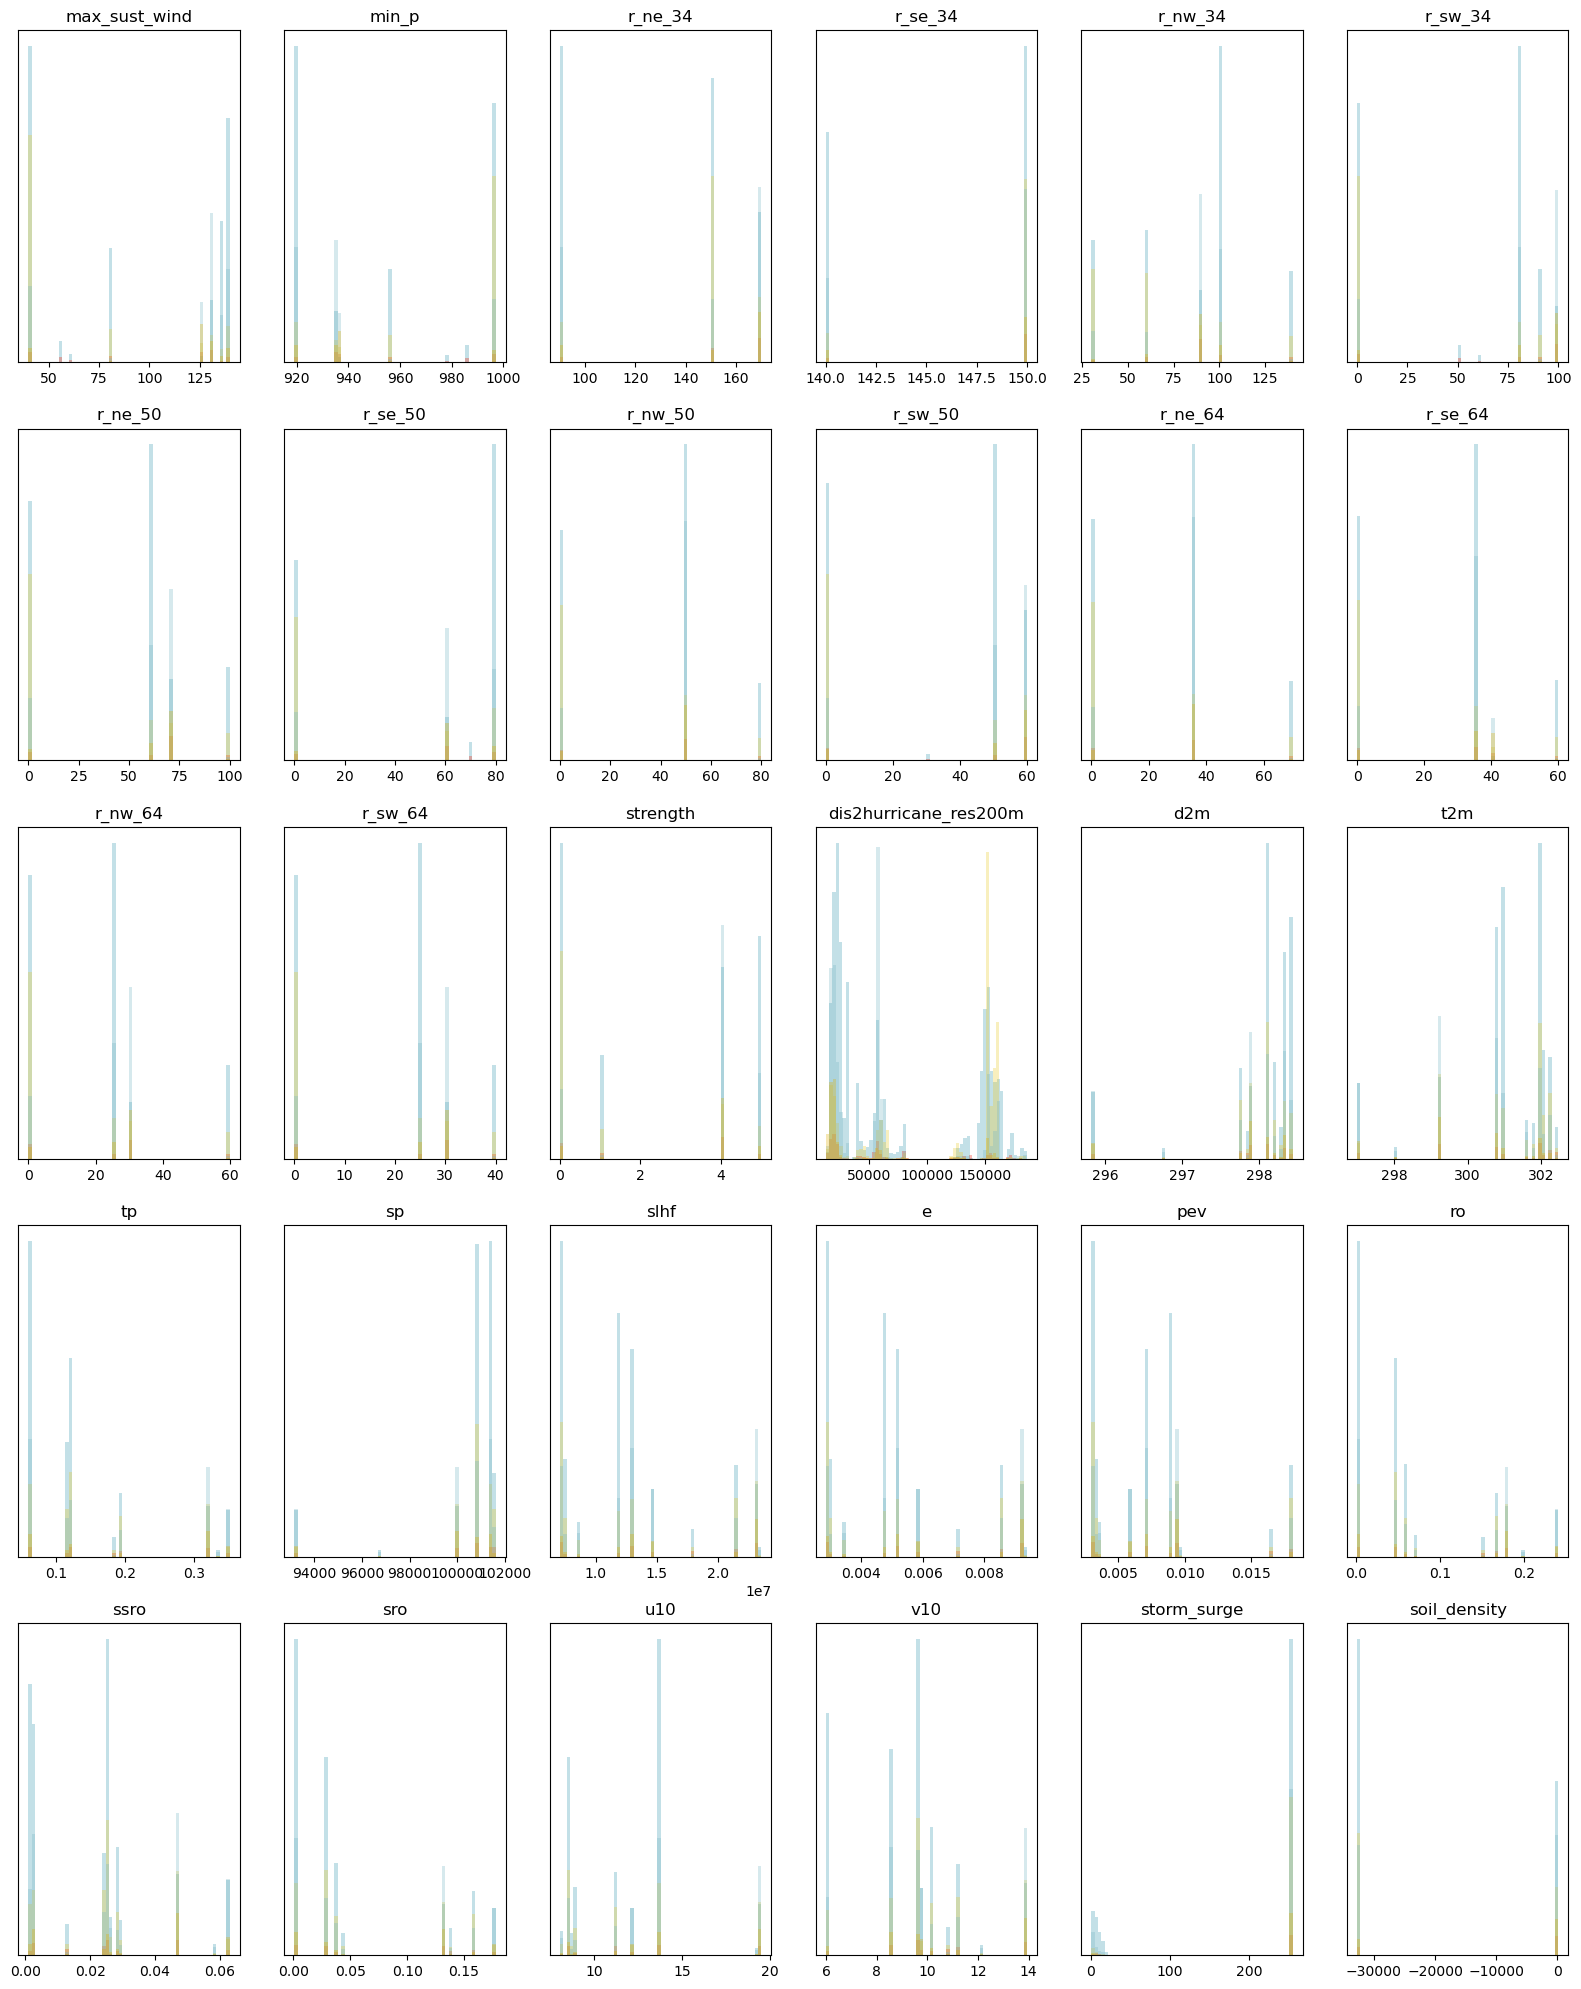

In [37]:
# TODO: make more clear
fig, axes = plt.subplots(5, 6, figsize=(20,25))	# better way to dynamically assign for a variable number of figures?

axes = axes.ravel()
bins = 60
palette = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]

# for each feature
for f_ind, f in enumerate(train_features):
	# and each damage class
	for t in df_merged_no_dups['damage_class'].unique():
		damage_data = df_merged_no_dups[df_merged_no_dups['damage_class'] == t]
		axes[f_ind].hist(damage_data[f], bins=bins, color=palette[t], alpha=0.3)
		axes[f_ind].axes.get_yaxis().set_visible(False)
	axes[f_ind].set_title(f)
	# TODO: add overall legend
	# axes[f].legend

Variances (Percentage):
[3.95777593e+01 2.02265558e+01 1.16363760e+01 7.22408405e+00
 4.64813924e+00 3.82941743e+00 2.67383844e+00 2.36502289e+00
 2.16373232e+00 1.72487332e+00 1.37986218e+00 1.19972574e+00
 5.65923113e-01 2.64325094e-01 1.76864499e-01 1.51534129e-01
 5.07936446e-02 3.99183544e-02 3.37286337e-02 2.19971461e-02
 1.72475742e-02 1.52473301e-02 9.84063239e-03 2.09097111e-03
 5.66333313e-04 3.27350186e-04 1.99673210e-04 8.84827213e-06
 2.72261649e-28 2.80479912e-29 1.86569370e-29 1.01147375e-29
 4.90613235e-30 1.74689973e-30 3.50115716e-31 3.09625564e-31
 1.11959620e-31]
Cumulative Variances (Percentage):
[ 39.57775928  59.80431507  71.44069108  78.66477513  83.31291436
  87.1423318   89.81617024  92.18119313  94.34492544  96.06979876
  97.44966094  98.64938667  99.21530979  99.47963488  99.65649938
  99.80803351  99.85882715  99.89874551  99.93247414  99.95447129
  99.97171886  99.98696619  99.99680682  99.9988978   99.99946413
  99.99979148  99.99999115 100.         100. 

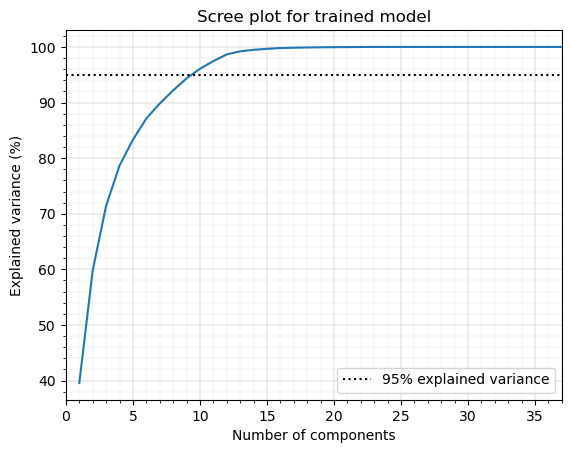

In [32]:
pca_analysis(df_merged_no_dups,train_features,'damage_class')

# Training and Testing Model

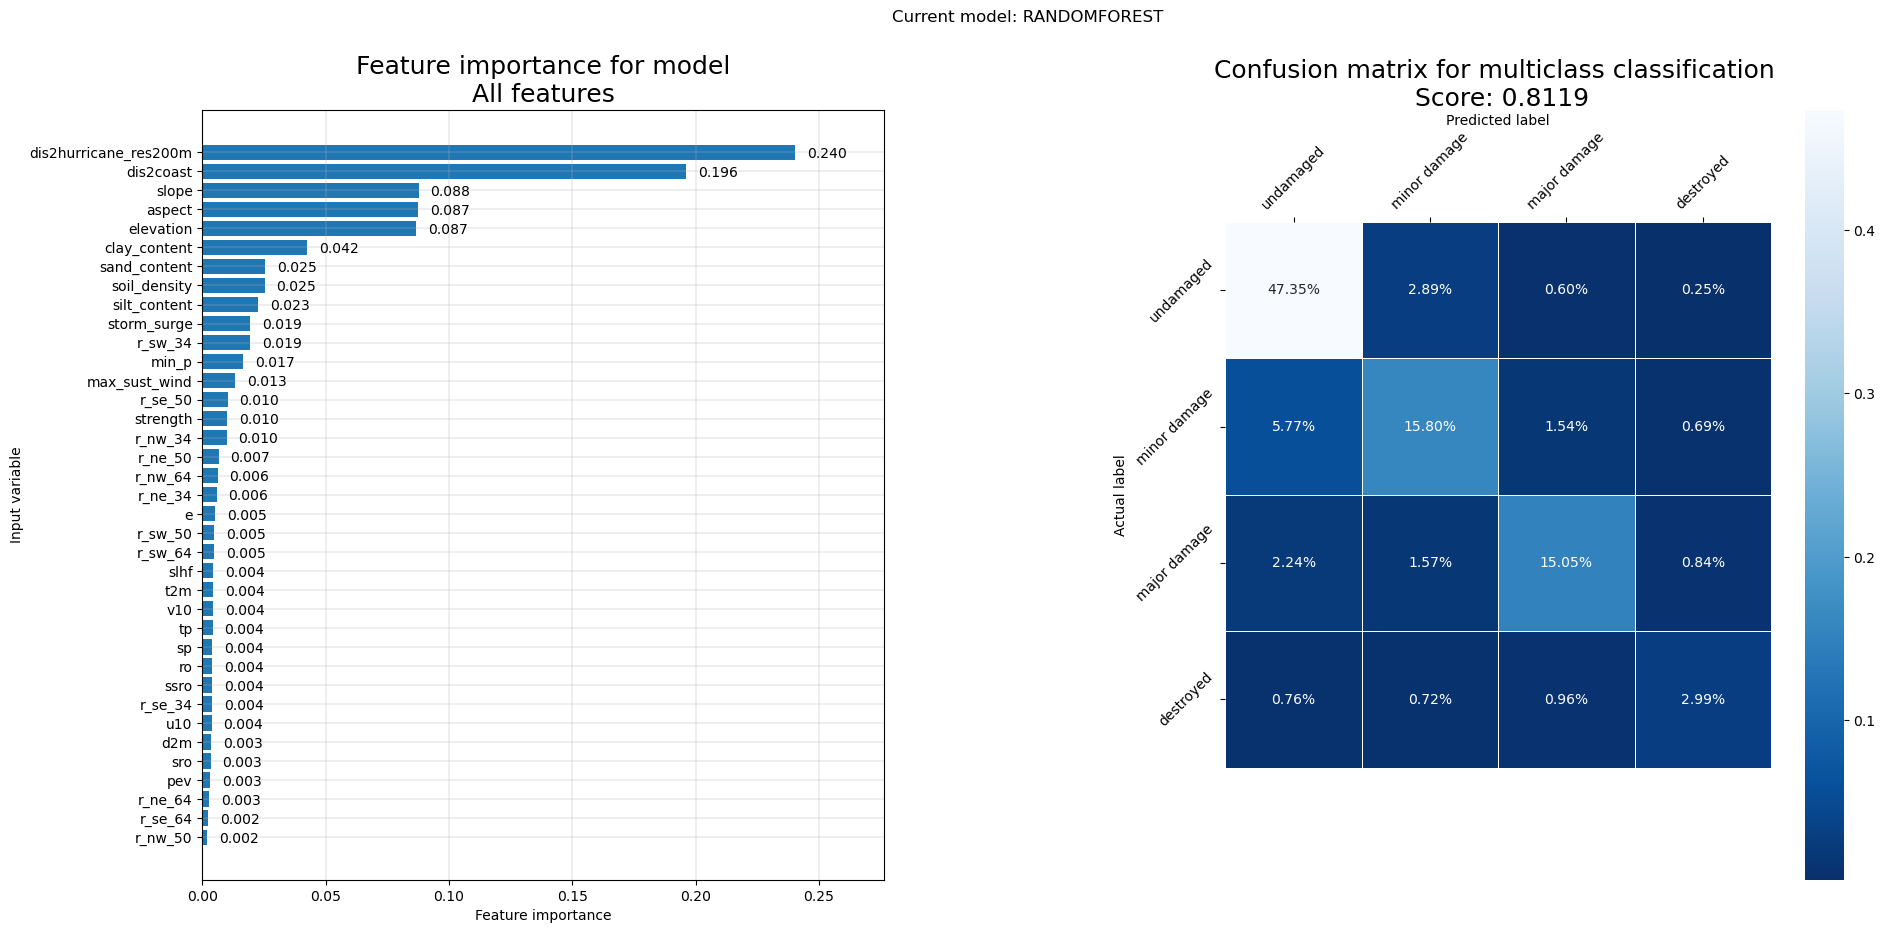

f1 score per class: [0.88338973 0.70571356 0.79536834 0.58701299]
f1 score macro: 0.7428711553112278
weighted f1 score: 0.8160193981089435
precision score: [0.9268437  0.66396697 0.76395014 0.55160391]
recall score: [0.84382787 0.75306196 0.82948157 0.62727994]
balanced accuracy: 0.7634128343562875
accuracy_score: 0.8118647269979218


In [40]:
# assign target variable
df_model_ready = assign_predictor(df_merged_no_dups, 'damage_class', drop_classes=[4], binary_classification=False)

# TODO: investigate class imbalance for hurricane datapoints in xbd dataset

# replace necessary columns with mean TODO: ask Ruari about this
cols_for_mean = ['soil_density', 'sand_content', 'clay_content', 'silt_content']
df_model_ready = replace_cols_with_mean(df_model_ready, cols_for_mean)
df_model_ready.head()

model, predictions, x_train, x_test, y_train, y_test, score, y_score, importances = train_test_display_model(
    df_model_ready, train_features, model_name='RandomForest')

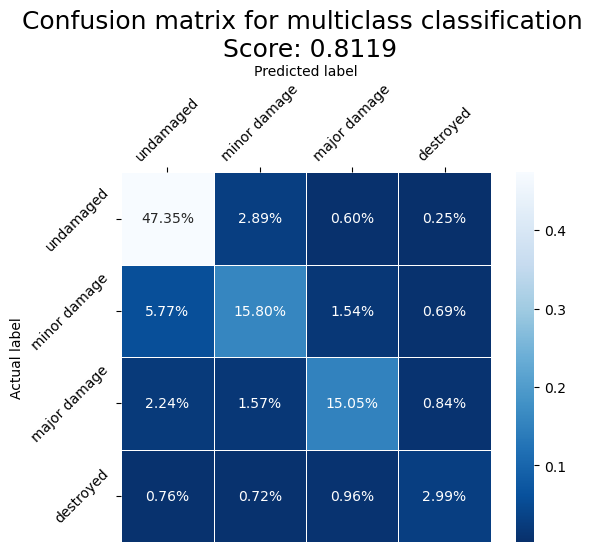

In [41]:
plot_confusion_matrix(y_test,predictions,score);

<AxesSubplot: title={'center': 'Feature importance for model\nTop 12 most significant features'}, xlabel='Feature importance', ylabel='Input variable'>

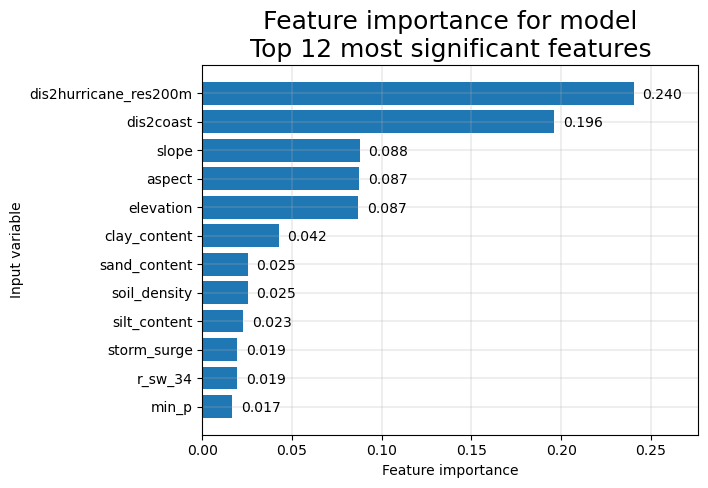

In [42]:
plot_importances(train_features,importances,12)

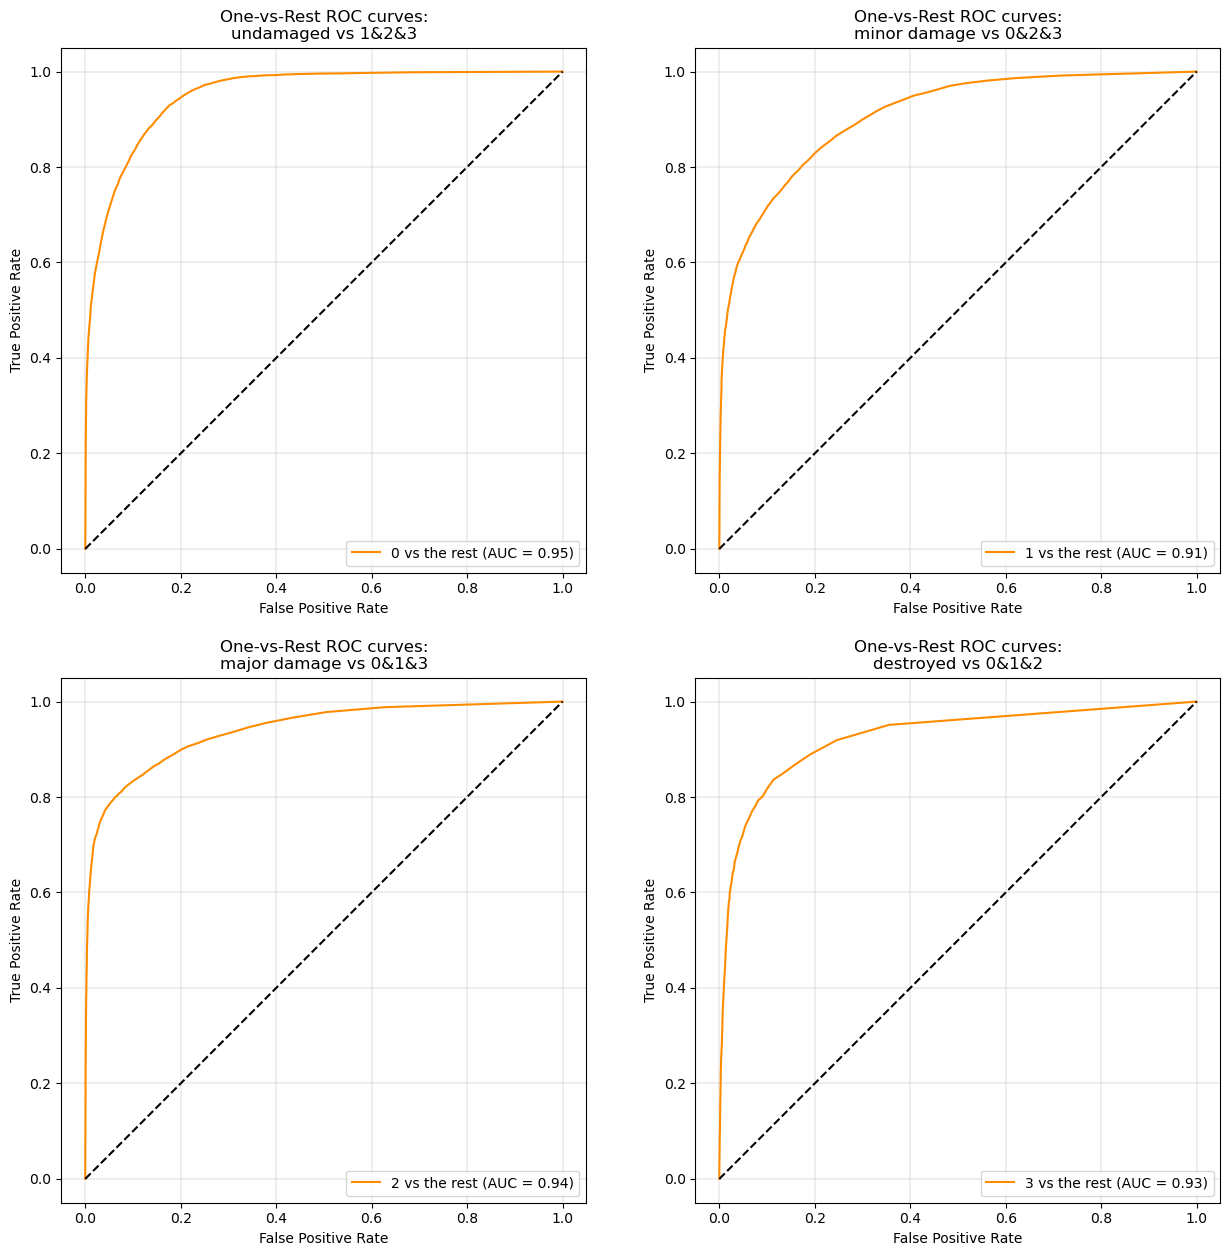

In [43]:
plot_roc_curves(y_test, y_score)

In [44]:
print(calc_curves_macro_av(y_test, y_score, curve_type='roc'))
print(calc_curves_macro_av(y_test, y_score, curve_type='pr'))

Macro-averaged One-vs-Rest ROC AUC score:
0.93
None
Macro-averaged One-vs-Rest PR AUC score:
1.00
None


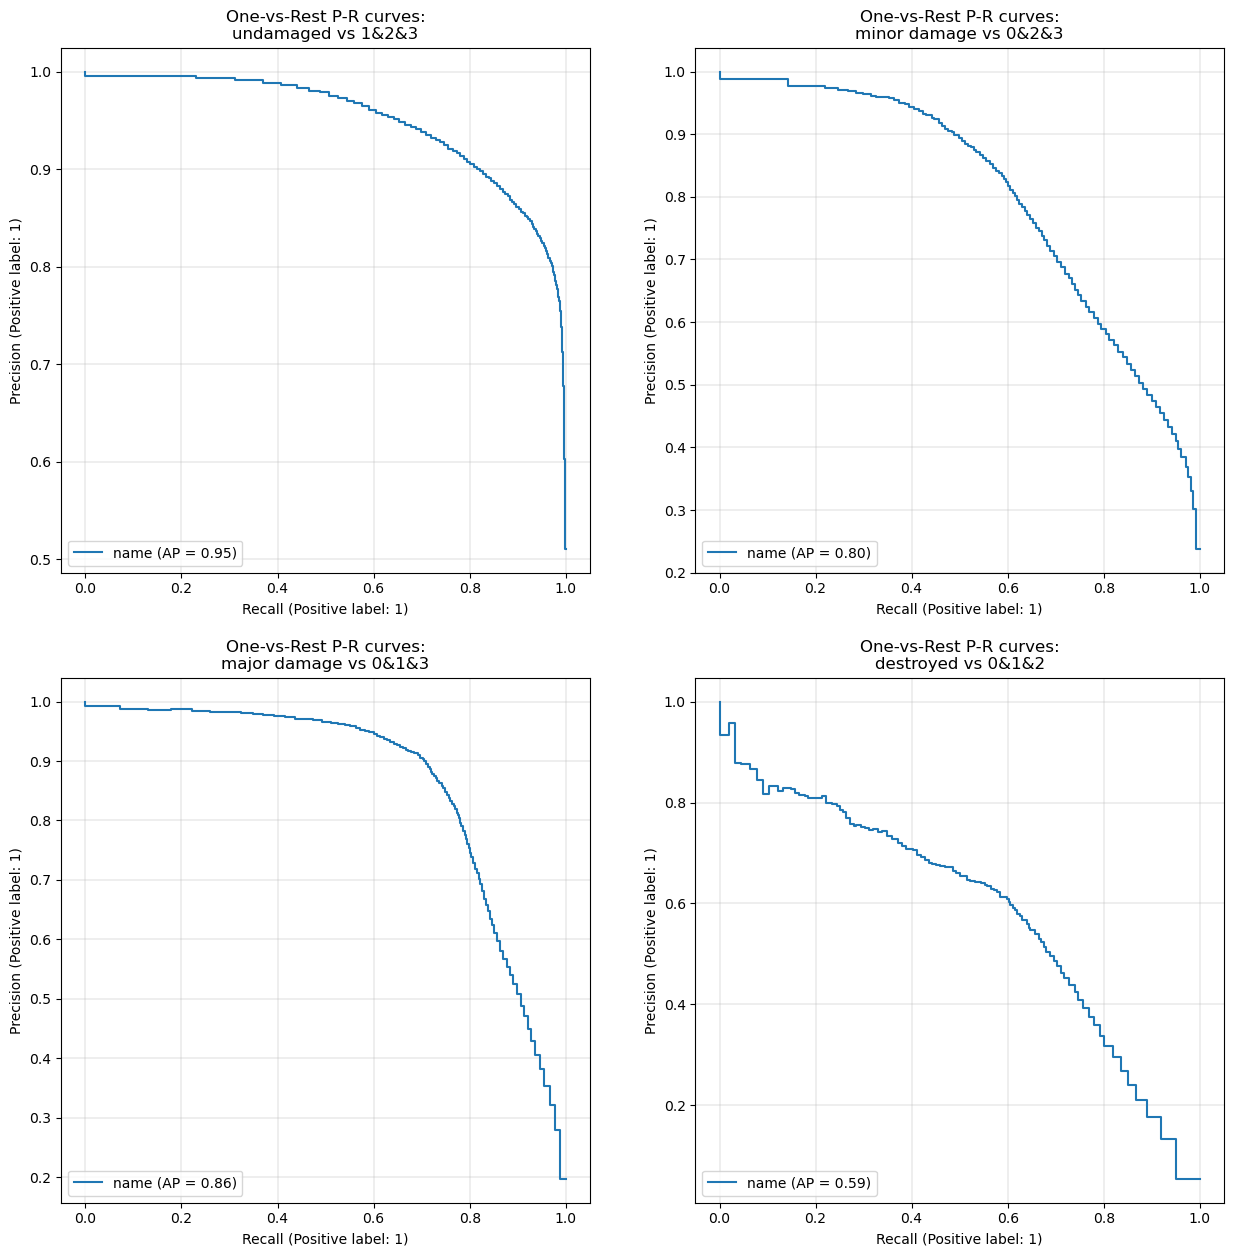

In [45]:
plot_pr_curves(y_test, y_score)

## A note on performance metrics (from [here](https://gist.github.com/huraji/5a5a3f86f309abcf9a5b4236834c36e0))
1. Classifying a single point can result in a true positive (truth = 1, guess = 1), a true negative (truth = 0, guess = 0), a false positive (truth = 0, guess = 1), or a false negative (truth = 1, guess = 0).
2. Accuracy measures how many classifications your algorithm got correct out of every classification it made.
3. Recall measures the percentage of the relevant items your classifier was able to successfully find.
4. Precision measures the percentage of items your classifier found that were actually relevant.
5. Precision and recall are tied to each other. As one goes up, the other will go down. Precision-recall curbes often used in situations where classes are heavily imbalanced
6. F1 score is a combination of precision and recall.
7. F1 score will be low if either precision or recall is low.

ROC – receiver operating characteristic (ROC) curve. Used to evaluate the performance of binary classification algorithms.

Another great [paper](https://support.sas.com/resources/papers/proceedings17/0942-2017.pdf), especially regarding class imbalances. Disagrees with description of balanced accuracy.

In [ ]:
# TODO: 
# better RF models
# xBD statistics – nearly done
# investigate effect on different data splits (e.g. withholding geographical regions in training to see generalisability)

## Investigation of hurricane track interpolation

# All code below this cell is deprecated 

In [ ]:
df_terrain_efs = pd.read_pickle('/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/processed_data/Terrian_EFs.pkl')

df_terrain_soil = df_terrain_efs.merge(df, left_index=True, right_index=True)
df_xbd_six_hourly_weather_terrain = df_terrain_soil.merge(df_noaa_six_hourly, left_index=True, right_index=True)
df_xbd_six_hourly_weather_terrain.head()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/processed_data/Terrian_EFs.pkl'

In [ ]:
### NO LONGER USING WEATHER STATION DATA

# df_weather_hourly = pd.read_pickle("/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/EFs/weather_data/xbd_weather_hourly.pkl")
# df_weather_hourly.head()

In [ ]:
df_xbd_six_hourly_weather_terrain.isnull().sum()

In [ ]:
df_xbd_six_hourly_weather_terrain.damage_class_y.value_counts()

In [ ]:
# drop columns containing nans (not technically necessary, just cleaning up)
df_xbd_six_hourly_weather_terrain.drop(['r_max_wind','stations_lat_lons'],axis=1)
# drop rows with damage_class "4" (unclassified)
df_xbd_six_hourly_weather_terrain = df_xbd_six_hourly_weather_terrain[df_xbd_six_hourly_weather_terrain['damage_class_y'] != 4]

In [ ]:
df_xbd_six_hourly_weather_terrain["y"] = df_xbd_six_hourly_weather_terrain["damage_class_y"]
df_xbd_six_hourly_weather_terrain["y"] = df_xbd_six_hourly_weather_terrain["y"].astype(int)

In [ ]:
df_binary = df_xbd_six_hourly_weather_terrain.copy()
# run this if you want to do binary classification
df_binary.loc[df_binary["y"] > 0, "y"] = 1

In [ ]:
df_xbd_six_hourly_weather_terrain.columns
df_xbd_six_hourly_weather_terrain.y.value_counts()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_xbd_six_hourly_weather_terrain[
    ['elevation', 'slope', 'aspect', 'dis2coast', 
     'flood_risk', 'storm_surge','soil_density', 'sand_content', 'clay_content', 
     'silt_content',
    'max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64', 'strength',
       'shortest_distance_to_track']],
                                                    df_xbd_six_hourly_weather_terrain["y"], test_size=0.25, random_state=1)

# Logistic Regression Model

In [ ]:
model = LogisticRegression(max_iter = 1e6)
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.coef_[0]
display(importance)

In [ ]:
confusion_matrix = confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Random forest hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(rf_random.best_params_)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

In [ ]:
# this section is Work In Progress. 

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = model.score(x_train, y_train)

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

In [ ]:
best["criterion"] = "entropy"

In [ ]:
model = RandomForestClassifier(**best)
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)
model.score(x_test, y_test)

In [ ]:
importance = best.feature_importances_
display(importance)

In [ ]:
confusion_matrix = confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Random Forest Model

In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.feature_importances_
display(importance)

In [ ]:
confusion_matrix = confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# XGBoost Model

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.feature_importances_
display(importance)

In [ ]:
confusion_matrix = confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()